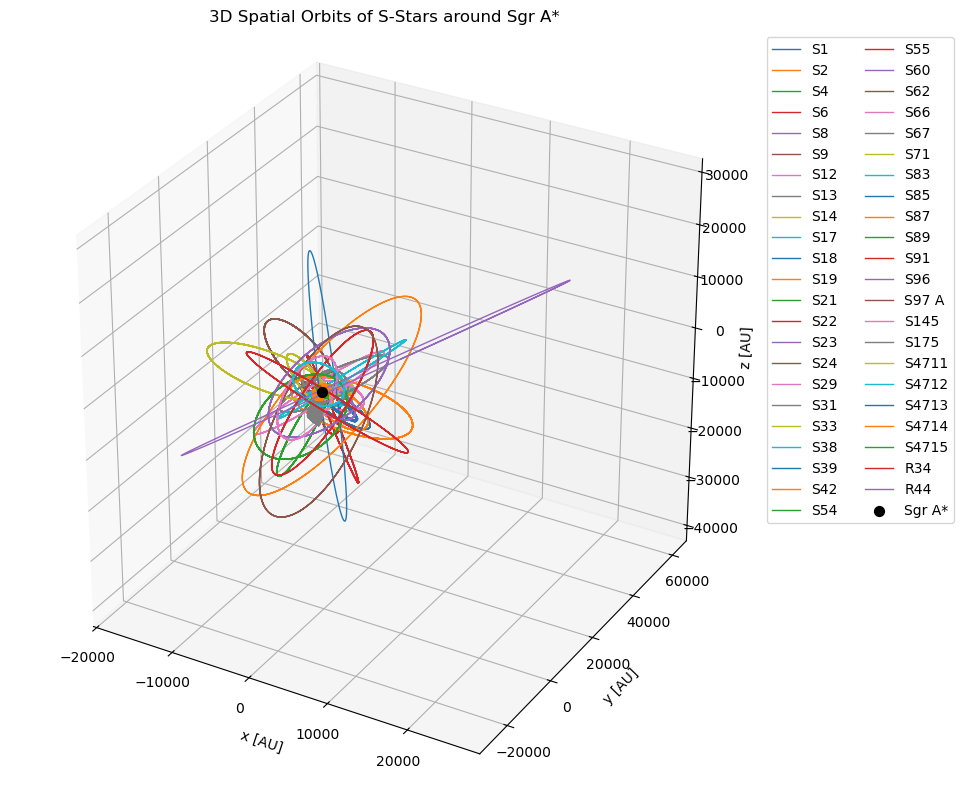

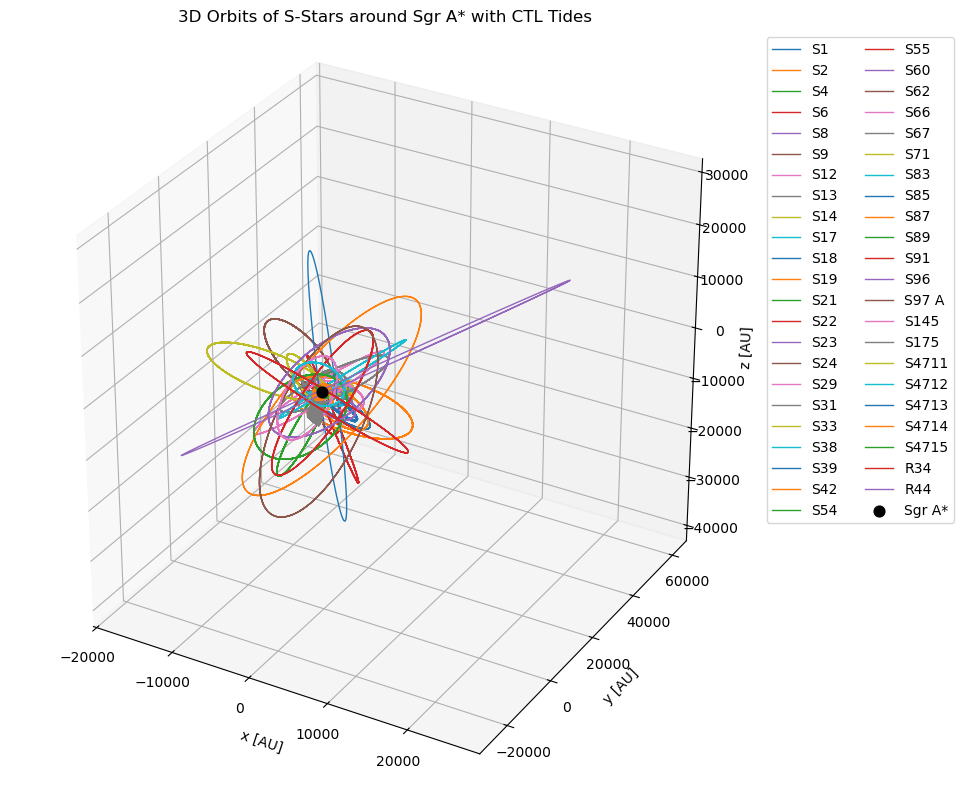

In [ ]:
import numpy as np
import pandas as pd
import rebound
import reboundx
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1) Physical constants & load CSV
# -----------------------------------------------------------------------------
# We define fundamental constants and load the S-star orbital element data
# from a CSV file.  All quantities are converted to SI units (kg, m, s).

G      = 6.67430e-11      # Gravitational constant [m^3 kg^-1 s^-2]
c      = 3.0e8            # Speed of light [m/s]
M_sun  = 1.989e30         # Solar mass [kg]
R_sun  = 6.957e8          # Solar radius [m]
AU     = 1.496e11         # Astronomical Unit [m]
year   = 3.154e7          # One year [s]
D_pc   = 8266.0           # Distance to Galactic Center [pc]
pc     = 3.086e16         # One parsec in meters [m]
M_BH   = 4.154e6 * M_sun  # Mass of Sgr A* (4.154e6 M_sun) [kg]

# Load the cluster CSV file containing S-star orbital elements.
# The CSV must have columns: id1, e, a [arcsec], omega1, i, omega2, P (yr), Tp (yr), Mass (Solar masses)
df = pd.read_csv('/Users/pythagoraslu/Desktop/black hole/cluster data.csv')

# Extract the list of star IDs and determine how many entries (N)
ids = df['id1'].tolist()
N   = len(ids)

# Pull out each column into numpy arrays (for faster processing)
e_arr        = df['e'].to_numpy()                 # Orbital eccentricity
a_arc_arr    = df['a'].to_numpy()                 # Semimajor axis [arcsec]
Omega_deg    = df['omega1'].to_numpy()            # Longitude of ascending node Ω [deg]
i_deg        = df['i'].to_numpy()                 # Inclination i [deg]
omega_deg    = df['omega2'].to_numpy()            # Argument of pericenter ω [deg]
P_yr_arr     = df['P (yr)'].to_numpy()            # Orbital period [yr]
Tperi_yr_arr = df['Tp (yr)'].to_numpy()           # Time of pericenter passage [yr]

# Star masses: if missing, fill with 10 M_sun.  Convert to kg.
mass_arr = df['Mass (Solar masses)'].fillna(10.0).to_numpy() * M_sun

# Convert semimajor axis from arcseconds to meters:
#   a_arcsec * D_pc [pc] gives a in AU, then multiply by AU constant.
a_m_arr = a_arc_arr * D_pc * AU  # semimajor axis in meters

# Determine total integration time as the longest orbital period (in seconds)
t_final = P_yr_arr.max() * year

# -----------------------------------------------------------------------------
# 2) Set up the REBOUND simulation
# -----------------------------------------------------------------------------
# We create a new rebound.Simulation, set gravitational constant, units,
# integrator, then add the central SMBH and include post-Newtonian (1PN)
# corrections as well as constant-time-lag tides via reboundx.

sim = rebound.Simulation()
sim.G = G
sim.units = ['kg', 'm', 's']     # Use physical SI units
sim.integrator = "ias15"         # High-accuracy integrator for few-body problems

# 2A) Add the central black hole (Sgr A*) at the origin, with zero velocity
sim.add(m=M_BH, x=0, y=0, z=0, vx=0, vy=0, vz=0)

# 2B) Attach REBOUNDx extras to add relativistic and tidal forces
rebx = reboundx.Extras(sim)

# Load 1PN Schwarzschild correction (named "gr" for general relativity)
gr = rebx.load_force("gr")
rebx.add_force(gr)
gr.params["c"] = c  # Set speed of light for PN calculations

# Load the constant-time-lag tide module ("tides_constant_time_lag")
tides = rebx.load_force("tides_constant_time_lag")
rebx.add_force(tides)

# -----------------------------------------------------------------------------
# 3) Add each S-star using orbital elements (a, e, i, Ω, ω, M0)
# -----------------------------------------------------------------------------
# For each row in the CSV, compute the orbital elements in SI units and
# add a test particle to the simulation.  Rebound will automatically solve
# Kepler’s equation to place the star at the correct position and velocity.

for i in range(N):
    # 3.1) Retrieve orbital elements for star i, converting angles to radians
    a_m   = a_m_arr[i]                    # semimajor axis [m]
    e     = e_arr[i]                      # eccentricity (unitless)
    inc   = np.deg2rad(i_deg[i])          # inclination [rad]
    Omega = np.deg2rad(Omega_deg[i])      # longitude of ascending node [rad]
    omega = np.deg2rad(omega_deg[i])      # argument of pericenter [rad]

    # 3.2) Period P and time of pericenter Tperi in seconds
    P_sec   = P_yr_arr[i] * year          # orbital period [s]
    Tperi_s = Tperi_yr_arr[i] * year      # time of pericenter [s]

    # 3.3) Compute mean anomaly M0 at t0 = 0.0 (simulation start time)
    #     If Tperi_s is in the past relative to t=0, (0 - Tperi)/P mod 1 gives fraction of orbit.
    M0 = 2 * np.pi * (((0.0 - Tperi_s) / P_sec) % 1.0)

    # 3.4) Add the star to the simulation.  Rebound’s sim.add will interpret
    #     these orbital elements around the central mass (m = M_BH at index 0).
    sim.add(
        m     = mass_arr[i],  # star mass [kg]
        a     = a_m,          # semimajor axis [m]
        e     = e,            # eccentricity
        inc   = inc,          # inclination [rad]
        Omega = Omega,        # longitude of ascending node [rad]
        omega = omega,        # argument of pericenter [rad]
        M     = M0            # mean anomaly at epoch [rad]
    )

# After adding all particles, shift to the center-of-mass frame for numerical stability
sim.move_to_com()

# -----------------------------------------------------------------------------
# 4) Assign CTL‐tide parameters on each particle
# -----------------------------------------------------------------------------
# We set the constant‐time‐lag tide parameters (k2 and τ) for the black hole
# and for each S-star.  For Sgr A*, we set no tidal deformation (k2=0, τ=0).
# For each star, we pick typical values (e.g., radius = 5 R_sun, Love number = 0.01).

# 4A) Configure the black hole (particle index 0)
bh = sim.particles[0]
bh.r               = 2 * G * M_BH / c**2   # Schwarzschild radius r_S = 2GM/c^2 [m]
bh.params["tctl_k2"]  = 0.0                # No tidal bulge for a point‐mass BH
bh.params["tctl_tau"] = 0.0                # No tidal lag

# 4B) Configure each S-star (particle indices 1 through N)
for p in sim.particles[1:]:
    # For simplicity, assume each star has radius = 5 R_sun
    R_star   = 5.0 * R_sun       # stellar radius [m]
    k2_star  = 0.01              # dimensionless Love number (tidal deformability)
    tau_star = 1e4               # tidal time lag [s]

    p.r = R_star                 # set the radius for tidal interactions
    p.params["tctl_k2"]  = k2_star
    p.params["tctl_tau"] = tau_star

# -----------------------------------------------------------------------------
# 5) Integrate the system over time
# -----------------------------------------------------------------------------
# We choose a fixed number of output steps (n_steps).  At each time, we
# integrate to that time, then record positions and velocities of each star.

n_steps = 5000
times   = np.linspace(0.0, t_final, n_steps)  # times from 0 to t_final [s]

# Preallocate arrays to store [time_index, star_index, (x,y,z)] and velocities
pos = np.zeros((n_steps, N, 3), dtype=float)
vel = np.zeros((n_steps, N, 3), dtype=float)

for k, t in enumerate(times):
    # Advance the simulation to time t (proper time for each particle is τ = t here)
    sim.integrate(t)

    # After integration, record each star’s Cartesian coordinates and velocities
    # Particles[0] is the black hole; particles[1:] are the N stars
    for star_idx, p in enumerate(sim.particles[1:], start=0):
        pos[k, star_idx, 0] = p.x  # x-position [m]
        pos[k, star_idx, 1] = p.y  # y-position [m]
        pos[k, star_idx, 2] = p.z  # z-position [m]
        vel[k, star_idx, 0] = p.vx # x-velocity [m/s]
        vel[k, star_idx, 1] = p.vy # y-velocity [m/s]
        vel[k, star_idx, 2] = p.vz # z-velocity [m/s]

# -----------------------------------------------------------------------------
# 6) Plot 3D orbits (static) with Matplotlib
# -----------------------------------------------------------------------------
# We create a 3D figure and plot each star’s trajectory over time, converting
# positions from meters to AU for readability.  We also mark the SMBH at the origin.

fig = plt.figure(figsize=(8, 8))
ax  = fig.add_subplot(projection='3d')  # 3D subplot

# Plot each S-star’s path
for i, name in enumerate(ids):
    # Convert from meters to AU for plotting
    xs = pos[:, i, 0] / AU  
    ys = pos[:, i, 1] / AU
    zs = pos[:, i, 2] / AU
    ax.plot(xs, ys, zs, label=name, linewidth=1)

# Mark Sgr A* (the central black hole) at the origin (0,0,0)
ax.scatter(0, 0, 0, c='k', s=60, label='Sgr A*')

# Ensure equal aspect ratio on all axes (so orbits are not distorted)
ax.set_box_aspect((1, 1, 1))

# Label axes (in AU)
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
ax.set_zlabel('z [AU]')
ax.set_title('3D Orbits of S-Stars around Sgr A* with CTL Tides')

# Place legend outside upper‐right corner for clarity if many stars
ax.legend(ncol=2, bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


Wrote interactive orbits to sgrA_orbits.html. Open that file in your browser.
